# Linear Regression Implementation

In this jupyter notebook we want to implementate Linear Regression with the help of Neural Networks. Despite doing a concise implementation of the linear regression in pytorch we compute some parts of the code from the scratch to gain deeper understanding of pytorch and what the functions of pytorch do.


In [1]:
# If you use jupyter notebook inside your virtual environment you don't have to run the first line
!pip install d2l
%matplotlib inline
import random
import torch
from d2l import torch as d2l
#conda install anaconda::torchvision

/Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <ABE0EE74-6D97-3B8C-B690-C44754774FBC> /Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <EA4AB737-8320-3563-ACC4-78D44C0573BA> /Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Generating the Dataset

To keep things simple, we will **construct an artificial dataset
according to a linear model with additive noise.**
Our task will be to recover this model's parameters
using the finite set of examples contained in our dataset.
We will keep the data low-dimensional so we can visualize it easily.
In the following code snippet, we generate a dataset
containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and** our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**

You could think of $\epsilon$ as capturing potential
measurement errors on the features and labels.
We will assume that the standard assumptions hold and thus
that $\epsilon$ obeys a normal distribution with mean of 0.
To make our problem easy, we will set its standard deviation to 0.01.
The following code generates our synthetic dataset.


In [2]:
def synthetic_data(w, b, num_examples): 
    """Generate y = Xw + b + noise."""
    X = torch.normal(mean=0, std=1, size=(num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(mean=0, std=0.01, size=y.shape)
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


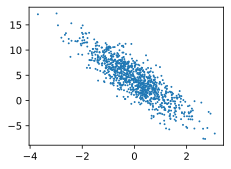

In [4]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

## Reading the Dataset from scratch

Recall that training models consists of
making multiple passes over the dataset,
grabbing one minibatch of examples at a time,
and using them to update our model.
Since this process is so fundamental
to training machine learning algorithms,
it is worth defining a utility function
to shuffle the dataset and access it in minibatches.

In the following code, we **define the `data_iter` function**
to demonstrate one possible implementation of this functionality.
The function **takes a batch size, a matrix of features,
and a vector of labels, yielding minibatches of the size `batch_size`.**
Each minibatch consists of a tuple of features and labels.

To understand the code below the following link might help you https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do


In [5]:
def data_iter_scratch(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In general, note that we want to use reasonably sized minibatches
to take advantage of the GPU hardware,
which excels at parallelizing operations.
Because each example can be fed through our models in parallel
and the gradient of the loss function for each example can also be taken in parallel,
GPUs allow us to process hundreds of examples in scarcely more time
than it might take to process just a single example.

To build some intuition, let us read and print
the first small batch of data examples.
The shape of the features in each minibatch tells us
both the minibatch size and the number of input features.
Likewise, our minibatch of labels will have a shape given by `batch_size`.


In [6]:
batch_size = 10

for X_scratch, y_scratch in data_iter_scratch(batch_size, features, labels):
    print(X_scratch, '\n', y_scratch)
    break

tensor([[ 1.1346, -0.2633],
        [ 0.9618, -0.1922],
        [ 0.9290, -1.1503],
        [-0.2494, -0.8293],
        [ 1.0143, -1.3532],
        [-0.4323, -0.8982],
        [ 0.1002,  2.2140],
        [ 1.2674, -1.4335],
        [-0.4833,  1.3193],
        [ 1.6646, -1.7365]]) 
 tensor([[ 7.3584],
        [ 6.7726],
        [ 9.9876],
        [ 6.5194],
        [10.8384],
        [ 6.3945],
        [-3.1224],
        [11.6029],
        [-1.2461],
        [13.4269]])


The iteration implemented from the scratch is good for didactic purposes,
it is inefficient in ways that might get us in trouble on real problems.
For example, it requires that we load all the data in memory
and that we perform lots of random memory access.
The built-in iterators implemented in a deep learning framework
are considerably more efficient and they can deal
with both data stored in files and data fed via data streams.

## Reading the Dataset in a concise way

Rather than rolling our own iterator,
we can **call upon the existing API in a framework to read data.**
We pass in `features` and `labels` as arguments and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).


In [7]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [8]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

Now we can use `data_iter` in much the same way as we called
the `data_iter` function in our implementation from the scratch.
To verify that it is working, we can read and print
the first minibatch of examples.
Comparing with the implementation from the scratch,
here we use `iter` to construct a Python iterator and use `next` to obtain the first item from the iterator.


In [9]:
next(iter(data_iter))

[tensor([[ 0.3814, -0.6740],
         [-1.0692,  0.3162],
         [-1.5249,  0.3441],
         [-0.8713, -0.5164],
         [-2.4478, -0.4175],
         [-0.5976,  0.0335],
         [ 0.4571, -1.9998],
         [ 0.5519,  0.3742],
         [ 0.4438,  1.5586],
         [-1.0905,  1.4954]]),
 tensor([[ 7.2618],
         [ 0.9879],
         [-0.0246],
         [ 4.2150],
         [ 0.7288],
         [ 2.8838],
         [11.8965],
         [ 4.0186],
         [-0.1987],
         [-3.0645]])]

## Initializing Model Parameters from the scratch

**Before we can begin optimizing our model's parameters** by minibatch stochastic gradient descent,
**we need to have some parameters in the first place.**
In the following code, we initialize weights by sampling
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01, and setting the bias to 0.


In [10]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

After initializing our parameters,
our next task is to update them until
they fit our data sufficiently well.
Each update requires taking the gradient
of our loss function with respect to the parameters.
Given this gradient, we can update each parameter
in the direction that may reduce the loss.

Since nobody wants to compute gradients explicitly
(this is tedious and error prone),
we use automatic differentiation to compute the gradient.


## Defining the Model from the scratch

Next, we must **define our model,
relating its inputs and parameters to its outputs.**
Recall that to calculate the output of the linear model,
we simply take the matrix-vector dot product
of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.
Note that below $\mathbf{Xw}$  is a vector and $b$ is a scalar.
Recall the broadcasting mechanism.
When we add a vector and a scalar,
the scalar is added to each component of the vector.


In [11]:
def linreg(X, w, b):
    """The linear regression model."""
    return torch.matmul(X, w) + b

## Defining the Model in a concise way

When we implemented linear regression from scratch,
we defined our model parameters explicitly
and coded up the calculations to produce output
using basic linear algebra operations.
You *should* know how to do this.
But once your models get more complex,
and once you have to do this nearly every day,
you will be glad for the assistance.
The situation is similar to coding up your own blog from scratch.
Doing it once or twice is rewarding and instructive,
but you would be a lousy web developer
if every time you needed a blog you spent a month
reinventing the wheel.

For standard operations, we can **use a framework's predefined layers,**
which allow us to focus especially
on the layers used to construct the model
rather than having to focus on the implementation.
We will first define a model variable `net`,
which will refer to an instance of the `Sequential` class.
The `Sequential` class defines a container
for several layers that will be chained together.
Given input data, a `Sequential` instance passes it through
the first layer, in turn passing the output
as the second layer's input and so forth.
In the following example, our model consists of only one layer,
so we do not really need `Sequential`.
But since nearly all of our future models
will involve multiple layers,
we will use it anyway just to familiarize you
with the most standard workflow.

Recall the architecture of a single-layer network.
The layer is said to be *fully-connected*
because each of its inputs is connected to each of its outputs
by means of a matrix-vector multiplication.


In PyTorch, the fully-connected layer is defined in the `Linear` class. Note that we passed two arguments into `nn.Linear`. The first one specifies the input feature dimension, which is 2, and the second one is the output feature dimension, which is a single scalar and therefore 1.


In [12]:
# `nn` is an abbreviation for neural networks
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

## Initializing Model Parameters in a concise way

Before using `net`, we need to **initialize the model parameters,**
such as the weights and bias in the linear regression model.
Deep learning frameworks often have a predefined way to initialize the parameters.
Here we specify that each weight parameter
should be randomly sampled from a normal distribution
with mean 0 and standard deviation 0.01.
The bias parameter will be initialized to zero.


As we have specified the input and output dimensions when constructing `nn.Linear`,
now we can access the parameters directly to specify their initial values.
We first locate the layer by `net[0]`, which is the first layer in the network,
and then use the `weight.data` and `bias.data` methods to access the parameters.
Next we use the replace methods `normal_` and `fill_` to overwrite parameter values.


In [13]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## Defining the Loss Function from the scratch

Since **updating our model requires taking
the gradient of our loss function,**
we ought to **define the loss function first.**
Here we will use the squared loss function.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [14]:
def squared_loss(y_hat, y):
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## Defining the Loss Function in a concise way


**The `MSELoss` class computes the mean squared error, also known as squared $L_2$ norm.**
By default it returns the average loss over examples.


In [15]:
loss = nn.MSELoss()

# Excurse Automatic Differentiation

Differentiation is a crucial step in nearly all deep learning optimization algorithms.
While the calculations for taking these derivatives are straightforward,
requiring only some basic calculus,
for complex models, working out the updates by hand
can be a pain (and often error-prone).

Deep learning frameworks expedite this work
by automatically calculating derivatives, i.e., *automatic differentiation*.
In practice,
based on our designed model
the system builds a *computational graph*,
tracking which data combined through
which operations to produce the output.
Automatic differentiation enables the system to subsequently backpropagate gradients.
Here, *backpropagate* simply means to trace through the computational graph,
filling in the partial derivatives with respect to each parameter.


## A Simple Example

As a toy example, say that we are interested
in **differentiating the function
$y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to the column vector $\mathbf{x}$.**
To start, let us create the variable `x` and assign it an initial value.


In [16]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

**Before we even calculate the gradient
of $y$ with respect to $\mathbf{x}$,
we will need a place to store it.**
It is important that we do not allocate new memory
every time we take a derivative with respect to a parameter
because we will often update the same parameters
thousands or millions of times
and could quickly run out of memory.
Note that a gradient of a scalar-valued function
with respect to a vector $\mathbf{x}$
is itself vector-valued and has the same shape as $\mathbf{x}$.


In [17]:
x.requires_grad_(True)  # Same as `x = torch.arange(4.0, requires_grad=True)`
x.grad  # The default value is None

**Now let us calculate $y$.**


In [18]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

Since `x` is a vector of length 4,
an dot product of `x` and `x` is performed,
yielding the scalar output that we assign to `y`.
Next, **we can automatically calculate the gradient of `y`
with respect to each component of `x`**
by calling the function for backpropagation and printing the gradient.


In [19]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

**The gradient of the function $y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to $\mathbf{x}$ should be $4\mathbf{x}$.**
Let us quickly verify that our desired gradient was calculated correctly.


In [20]:
x.grad == 4 * x

tensor([True, True, True, True])

**Now let us calculate another function of `x`.**

In [21]:
# PyTorch accumulates the gradient in default, we need to clear the previous
# values
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## Backward for Non-Scalar Variables

Technically, when `y` is not a scalar,
the most natural interpretation of the differentiation of a vector `y`
with respect to a vector `x` is a matrix.
For higher-order and higher-dimensional `y` and `x`,
the differentiation result could be a high-order tensor.

However, while these more exotic objects do show up
in advanced machine learning (including **in deep learning**),
more often **when we are calling backward on a vector,**
we are trying to calculate the derivatives of the loss functions
for each constituent of a *batch* of training examples.
Here, **our intent is** not to calculate the differentiation matrix
but rather **the sum of the partial derivatives
computed individually for each example** in the batch.


In [22]:
# Invoking `backward` on a non-scalar requires passing in a `gradient` argument
# which specifies the gradient of the differentiated function w.r.t `self`.
# In our case, we simply want to sum the partial derivatives, so passing
# in a gradient of ones is appropriate
x.grad.zero_()
y = x * x
# y.backward(torch.ones(len(x))) equivalent to the below
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

# End of Excurse

## Defining the Optimization Algorithm from the scratch

As we discussed, linear regression has a closed-form solution.
However, this is not a book about linear regression:
it is a book about deep learning.
Since none of the other models that this book introduces
can be solved analytically, we will take this opportunity to introduce your first working example of
minibatch stochastic gradient descent.

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.
The following code applies the minibatch stochastic gradient descent update,
given a set of parameters, a learning rate, and a batch size.
The size of the update step is determined by the learning rate `lr`.
Because our loss is calculated as a sum over the minibatch of examples,
we normalize our step size by the batch size (`batch_size`),
so that the magnitude of a typical step size
does not depend heavily on our choice of the batch size.


In [23]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

It is necessary to use torch.no_grad() here, because in python it is not possible to do in-place operations like -= or += on variables with requires_grad=True. You can find more information here https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308/2

## Training from the scratch

Now that we have all of the parts in place,
we are ready to **implement the main training loop.**
It is crucial that you understand this code
because you will see nearly identical training loops
over and over again throughout your career in deep learning.

In each iteration, we will grab a minibatch of training examples,
and pass them through our model to obtain a set of predictions.
After calculating the loss, we initiate the backwards pass through the network,
storing the gradients with respect to each parameter.
Finally, we will call the optimization algorithm `sgd`
to update the model parameters.

In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
(assuming that the number of examples is divisible by the batch size).
The number of epochs `num_epochs` and the learning rate `lr` are both hyperparameters,
which we set here to 3 and 0.03, respectively.
Unfortunately, setting hyperparameters is tricky
and requires some adjustment by trial and error.
We elide these details for now but revise them
later.


In [24]:
lr = 0.03
num_epochs = 3
network = linreg

In [25]:
for epoch in range(num_epochs):
    for X, y in data_iter_scratch(batch_size, features, labels):
        l = squared_loss(network(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad(): # This is kind of a validation - we compute the loss on all features to see, how accurate is our performance
    #we don't want to backpropagte throuth this loss - therefore we need the torch.no_grad() statement
        train_l = squared_loss(network(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.037487
epoch 2, loss 0.000138
epoch 3, loss 0.000051


In this case, because we synthesized the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can **evaluate our success in training
by comparing the true parameters
with those that we learned** through our training loop.
Indeed they turn out to be very close to each other.


In [26]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([-0.0002, -0.0005], grad_fn=<SubBackward0>)
error in estimating b: tensor([6.8665e-05], grad_fn=<RsubBackward1>)


Note that we should not take it for granted
that we are able to recover the parameters perfectly.
However, in machine learning, we are typically less concerned
with recovering true underlying parameters,
and more concerned with parameters that lead to highly accurate prediction.
Fortunately, even on difficult optimization problems,
stochastic gradient descent can often find remarkably good solutions,
owing partly to the fact that, for deep networks,
there exist many configurations of the parameters
that lead to highly accurate prediction.


## Summary

* We saw how a deep network can be implemented and optimized from scratch, using just tensors and auto differentiation, without any need for defining layers or fancy optimizers.
* This section only scratches the surface of what is possible. In the following sections, we will describe additional models based on the concepts that we have just introduced and learn how to implement them more concisely.



## Defining the Optimization Algorithm in a concise way


Minibatch stochastic gradient descent is a standard tool
for optimizing neural networks
and thus PyTorch supports it alongside a number of
variations on this algorithm in the `optim` module.
When we **instantiate an `SGD` instance,**
we will specify the parameters to optimize over
(obtainable from our net via `net.parameters()`), with a dictionary of hyperparameters
required by our optimization algorithm.
Minibatch stochastic gradient descent just requires that
we set the value `lr`, which is set to 0.03 here.


In [27]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## Training

You might have noticed that expressing our model through
high-level APIs of a deep learning framework
requires comparatively few lines of code.
We did not have to individually allocate parameters,
define our loss function, or implement minibatch stochastic gradient descent.
Once we start working with much more complex models,
advantages of high-level APIs will grow considerably.
However, once we have all the basic pieces in place,
**the training loop itself is strikingly similar
to what we did when implementing everything from scratch.**

To refresh your memory: for some number of epochs,
we will make a complete pass over the dataset (`train_data`),
iteratively grabbing one minibatch of inputs
and the corresponding ground-truth labels.
For each minibatch, we go through the following ritual:

* Generate predictions by calling `net(X)` and calculate the loss `l` (the forward propagation).
* Calculate gradients by running the backpropagation.
* Update the model parameters by invoking our optimizer.

For good measure, we compute the loss after each epoch and print it to monitor progress.


In [28]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000234
epoch 2, loss 0.000101
epoch 3, loss 0.000102


Below, we **compare the model parameters learned by training on finite data
and the actual parameters** that generated our dataset.
To access parameters,
we first access the layer that we need from `net`
and then access that layer's weights and bias.
As in our from-scratch implementation,
note that our estimated parameters are
close to their ground-truth counterparts.


In [29]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([-0.0008,  0.0006])
error in estimating b: tensor([-0.0005])


## Summary


* Using PyTorch's high-level APIs, we can implement models much more concisely.
* In PyTorch, the `data` module provides tools for data processing, the `nn` module defines a large number of neural network layers and common loss functions.
* We can initialize the parameters by replacing their values with methods ending with `_`.


## Exercises


1. Is it a good idea to initialize the weights to zero? You can set the values of the network to zero by using net[0].weight.data.fill_(0)

#### Sol
- **Single-layer linear models** (plain linear regression) can learn even if all weights are initialized to zero, because each feature produces a different gradient $\nabla_{w_j}L = -\frac{1}{n} \sum_i x_{ij}(y_i - \hat{y}_i)$
    
- **Deeper networks** require symmetry breaking: if every neuron in a layer starts with the same weights, they remain identical throughout training.
    
- **Best practice:** initialize with small random values unless we are certain we only need a single linear layer.
    

2. Review the PyTorch documentation to see what loss functions are provided. Replace (in the concise version) the loss by Huber's loss.

#### Sol

PyTorch offers two closely related implementations:

```python
from torch import nn

# Classic Huber (delta = 1.0 by default)
LossFn = nn.HuberLoss(delta=1.0)

# —or— the “Smooth L1” variant
# LossFn = nn.SmoothL1Loss()
```

Then in the training loop use:

```python
BatchLoss = LossFn(Net(XBatch), YBatch)
```

instead of `nn.MSELoss()`.


3. Review the PyTorch documentation to see what initialization functions are provided. Specify a linear layer and check whether an initialization is made automatically or not.

#### Sol

- **Common in** `torch.nn.init`:
    
    - `init.normal_`, `init.uniform_`, `init.constant_`
        
    - `init.xavier_uniform_`, `init.xavier_normal_`
        
    - `init.kaiming_uniform_`, `init.kaiming_normal_`
        
    - `init.orthogonal_`, `init.eye_`, etc.
        
- **`nn.Linear` default (source):**
    
    ```python
    # Weights
    init.kaiming_uniform_(self.weight, a=math.sqrt(5))
    # Bias
    fanIn, _ = init._calculate_fan_in_and_fan_out(self.weight)
    bound    = 1 / math.sqrt(fanIn)
    init.uniform_(self.bias, -bound, bound)
    ```
    
    So by default **weights** use Kaiming-uniform and **bias** is uniform around zero.
    

4. How do you access the gradient of `net[0].weight`?

#### Sol

After `Loss.backward()` has been called, gradients are stored in each parameter’s `.grad` attribute:

```python
weight_grad = Net[0].weight.grad
bias_grad   = Net[0].bias.grad
```

These tensors have the same shape as the corresponding parameters and hold the backpropagated gradients.